In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [ ]:
linkwhite='https://drive.google.com/open?id=1XBIV3UcGD9huBlsotNAH2pTlwoajNx0Q'
fluff, id2 = linkwhite.split('=')
print (id2)

downloaded = drive.CreateFile({'id':id2}) 
downloaded.GetContentFile('credit_dataset.csv')  
dataframe = pd.read_csv('credit_dataset.csv', index_col=0)
dataframe.head()

1XBIV3UcGD9huBlsotNAH2pTlwoajNx0Q


,ID,GENDER,CAR,REALITY,NO_OF_CHILD,INCOME,INCOME_TYPE,EDUCATION_TYPE,FAMILY_TYPE,HOUSE_TYPE,FLAG_MOBIL,WORK_PHONE,PHONE,E_MAIL,FAMILY SIZE,BEGIN_MONTH,AGE,YEARS_EMPLOYED,TARGET
0,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,2.0,29,59,3,0
1,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,1.0,4,52,8,0
2,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,1.0,26,52,8,0
3,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,1.0,26,52,8,0
4,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,1.0,38,52,8,0


In [ ]:
# Change behaviour globaly
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
# Copy
df = dataframe.copy()

In [ ]:
# Shape dataframe
print('Rows    :', df.shape[0])
print('Columns :', df.shape[1])

Rows    : 25134
Columns : 19


In [ ]:
# Preview NULL values
df.isna().sum()

ID                0
GENDER            0
CAR               0
REALITY           0
NO_OF_CHILD       0
INCOME            0
INCOME_TYPE       0
EDUCATION_TYPE    0
FAMILY_TYPE       0
HOUSE_TYPE        0
FLAG_MOBIL        0
WORK_PHONE        0
PHONE             0
E_MAIL            0
FAMILY SIZE       0
BEGIN_MONTH       0
AGE               0
YEARS_EMPLOYED    0
TARGET            0
dtype: int64

In [ ]:
# Dtytes
df.dtypes

ID                  int64
GENDER             object
CAR                object
REALITY            object
NO_OF_CHILD         int64
INCOME            float64
INCOME_TYPE        object
EDUCATION_TYPE     object
FAMILY_TYPE        object
HOUSE_TYPE         object
FLAG_MOBIL          int64
WORK_PHONE          int64
PHONE               int64
E_MAIL              int64
FAMILY SIZE       float64
BEGIN_MONTH         int64
AGE                 int64
YEARS_EMPLOYED      int64
TARGET              int64
dtype: object

In [ ]:
# Preview unique values
df.nunique()

ID                25134
GENDER                2
CAR                   2
REALITY               2
NO_OF_CHILD           9
INCOME              195
INCOME_TYPE           5
EDUCATION_TYPE        5
FAMILY_TYPE           5
HOUSE_TYPE            6
FLAG_MOBIL            1
WORK_PHONE            2
PHONE                 2
E_MAIL                2
FAMILY SIZE          10
BEGIN_MONTH          61
AGE                  47
YEARS_EMPLOYED       43
TARGET                2
dtype: int64

TARGET variable class distribution

0   0.983
1   0.017
Name: TARGET, dtype: float64


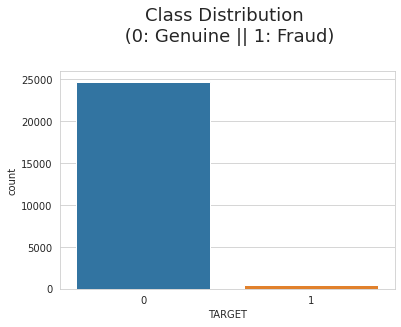

In [ ]:
sns.countplot(df.TARGET).set_title('Class Distribution \n (0: Genuine || 1: Fraud)', size=18, pad=30)
print(df.TARGET.value_counts(normalize=True))
plt.show()

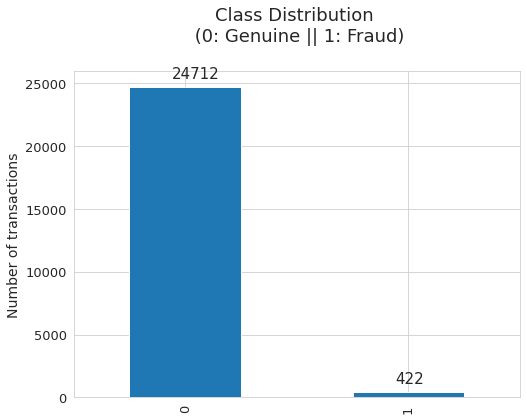

In [ ]:
ax = df['TARGET'].value_counts().plot(kind='bar', figsize=(8,6), fontsize=13)
ax.set_title('Class Distribution \n (0: Genuine || 1: Fraud)', size=18, pad=30)
ax.set_ylabel('Number of transactions', fontsize=14)

for i in ax.patches:
    ax.text(i.get_x() + 0.19, i.get_height() + 700, str(round(i.get_height(), 2)), fontsize=15)

Data preparation

In [ ]:
# Remap to integers
df['GENDER'] = [0 if x == 'M' else 1 for x in df['GENDER']]
df['CAR'] = [1 if x == 'Y' else 0 for x in df['CAR']]
df['REALITY'] = [1 if x == 'Y' else 0 for x in df['REALITY']]

# Create dummy variables
dummy_income_type = pd.get_dummies(df['INCOME_TYPE'], prefix='INC_TYPE', drop_first=True)
dummy_edu_type = pd.get_dummies(df['EDUCATION_TYPE'], prefix='EDU_TYPE', drop_first=True)
dummy_family_type = pd.get_dummies(df['FAMILY_TYPE'], prefix='FAM_TYPE', drop_first=True)
dummy_house_type = pd.get_dummies(df['HOUSE_TYPE'], prefix='HOUSE_TYPE', drop_first=True)

# Drop unnecessary columns
to_drop = ['ID', 'FLAG_MOBIL', 'INCOME_TYPE',
           'EDUCATION_TYPE', 'FAMILY_TYPE', 'HOUSE_TYPE']
df.drop(to_drop, axis=1, inplace=True)

# Merge into a single dataframe
merged = pd.concat([df, dummy_income_type, dummy_edu_type, dummy_family_type, dummy_house_type], axis=1)
merged.head()

,GENDER,CAR,REALITY,NO_OF_CHILD,INCOME,WORK_PHONE,PHONE,E_MAIL,FAMILY SIZE,BEGIN_MONTH,AGE,YEARS_EMPLOYED,TARGET,INC_TYPE_Pensioner,INC_TYPE_State servant,INC_TYPE_Student,INC_TYPE_Working,EDU_TYPE_Higher education,EDU_TYPE_Incomplete higher,EDU_TYPE_Lower secondary,EDU_TYPE_Secondary / secondary special,FAM_TYPE_Married,FAM_TYPE_Separated,FAM_TYPE_Single / not married,FAM_TYPE_Widow,HOUSE_TYPE_House / apartment,HOUSE_TYPE_Municipal apartment,HOUSE_TYPE_Office apartment,HOUSE_TYPE_Rented apartment,HOUSE_TYPE_With parents
0,0,1,1,0,112500.000,0,0,0,2.000,29,59,3,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0
1,1,0,1,0,270000.000,0,1,1,1.000,4,52,8,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
2,1,0,1,0,270000.000,0,1,1,1.000,26,52,8,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
3,1,0,1,0,270000.000,0,1,1,1.000,26,52,8,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
4,1,0,1,0,270000.000,0,1,1,1.000,38,52,8,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
# # minmax: scales and translates each feature individually such that it is in the range of 0 to 1

# Scale only columns where value > 1
to_scale = [col for col in df.columns if df[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(merged[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# Replace original columns with scaled values
for col in scaled:
  merged[col] = scaled[col]

merged.head()

,GENDER,CAR,REALITY,NO_OF_CHILD,INCOME,WORK_PHONE,PHONE,E_MAIL,FAMILY SIZE,BEGIN_MONTH,AGE,YEARS_EMPLOYED,TARGET,INC_TYPE_Pensioner,INC_TYPE_State servant,INC_TYPE_Student,INC_TYPE_Working,EDU_TYPE_Higher education,EDU_TYPE_Incomplete higher,EDU_TYPE_Lower secondary,EDU_TYPE_Secondary / secondary special,FAM_TYPE_Married,FAM_TYPE_Separated,FAM_TYPE_Single / not married,FAM_TYPE_Widow,HOUSE_TYPE_House / apartment,HOUSE_TYPE_Municipal apartment,HOUSE_TYPE_Office apartment,HOUSE_TYPE_Rented apartment,HOUSE_TYPE_With parents
0,0,1,1,0.000,0.055,0,0,0,0.053,0.483,0.826,0.070,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0
1,1,0,1,0.000,0.157,0,1,1,0.000,0.067,0.674,0.186,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
2,1,0,1,0.000,0.157,0,1,1,0.000,0.433,0.674,0.186,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
3,1,0,1,0.000,0.157,0,1,1,0.000,0.433,0.674,0.186,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
4,1,0,1,0.000,0.157,0,1,1,0.000,0.633,0.674,0.186,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0


### Pycaret

In [ ]:
!pip install --upgrade pycaret

In [ ]:
import pycaret

In [ ]:
from pycaret.classification import *

In [ ]:
exp_clf = setup(
    data=merged, target='TARGET',
    session_id=123,
    remove_outliers=True,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.90,
    normalize=True,
    normalize_method='minmax',
    transformation=True,
    feature_selection=True,
    fix_imbalance=True,
    profile=True
    )

In [ ]:
# Report the best models based on roc auc metric
top3_models = compare_models(n_select=3, sort='AUC', round=3)
print(top3_models)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.981,0.736,0.171,0.342,0.224,0.216,0.231,2.627
et,Extra Trees Classifier,0.978,0.720,0.182,0.256,0.210,0.199,0.204,2.007
xgboost,Extreme Gradient Boosting,0.983,0.706,0.171,0.465,0.242,0.236,0.269,3.963
catboost,CatBoost Classifier,0.983,0.702,0.167,0.413,0.233,0.226,0.252,18.281
lightgbm,Light Gradient Boosting Machine,0.981,0.701,0.167,0.349,0.222,0.214,0.231,0.557
knn,K Neighbors Classifier,0.911,0.673,0.379,0.072,0.121,0.097,0.135,1.563
gbc,Gradient Boosting Classifier,0.947,0.657,0.134,0.051,0.074,0.052,0.059,4.286
ada,Ada Boost Classifier,0.862,0.613,0.220,0.027,0.049,0.021,0.034,1.160
dt,Decision Tree Classifier,0.964,0.596,0.186,0.115,0.142,0.124,0.128,0.184
lda,Linear Discriminant Analysis,0.689,0.583,0.432,0.022,0.043,0.013,0.034,0.155


[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False), ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=

In [ ]:
rf = create_model('rf', round=3)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.981,0.721,0.111,0.273,0.158,0.150,0.166
1,0.980,0.682,0.185,0.312,0.233,0.223,0.231
2,0.983,0.702,0.148,0.400,0.216,0.209,0.236
3,0.981,0.722,0.115,0.273,0.162,0.154,0.169
4,0.984,0.652,0.185,0.500,0.270,0.264,0.298
5,0.980,0.802,0.222,0.333,0.267,0.257,0.263
6,0.983,0.818,0.148,0.400,0.216,0.209,0.236
7,0.979,0.788,0.222,0.300,0.255,0.245,0.248
8,0.979,0.674,0.148,0.250,0.186,0.176,0.182
9,0.981,0.794,0.222,0.375,0.279,0.270,0.280


In [ ]:
# Tune model hyperparameter
tuned_rf = tune_model(rf, round=3, optimize='AUC')
print(tuned_rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.887,0.673,0.185,0.029,0.050,0.023,0.035
1,0.880,0.724,0.296,0.042,0.074,0.047,0.074
2,0.889,0.684,0.148,0.024,0.041,0.014,0.021
3,0.895,0.618,0.192,0.031,0.054,0.028,0.042
4,0.873,0.640,0.370,0.049,0.086,0.059,0.097
5,0.870,0.709,0.407,0.052,0.092,0.065,0.108
6,0.876,0.666,0.296,0.041,0.071,0.044,0.071
7,0.873,0.630,0.296,0.040,0.070,0.043,0.069
8,0.867,0.571,0.222,0.029,0.051,0.023,0.038
9,0.883,0.692,0.259,0.038,0.067,0.040,0.061


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=190, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


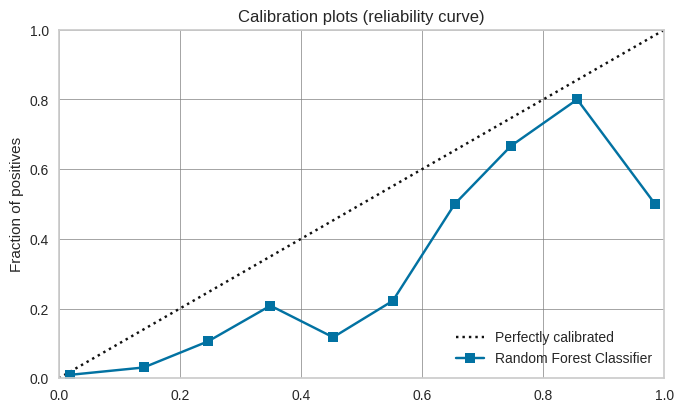

In [ ]:
plot_model(rf, plot='calibration')

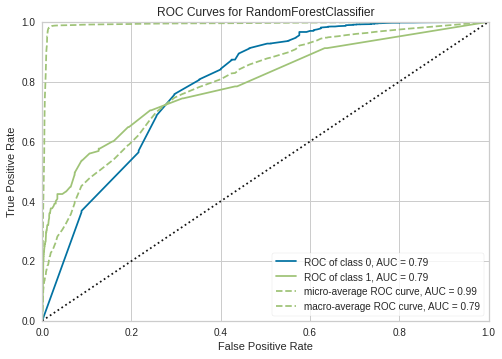

In [ ]:
plot_model(rf, plot='auc')

In [ ]:
evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
!pip install shap

     |████████████████████████████████| 327kB 6.8MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463895 sha256=50d18e7ad62210e9ab71096756bd6d6a7d8126b26000567c31a36e6c58918c0b
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


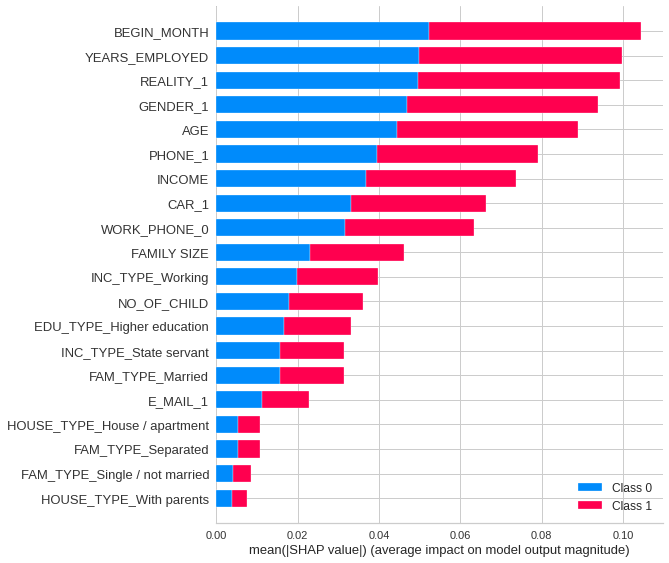

In [ ]:
interpret_model(rf)

In [ ]:
predict_model(rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.983,0.794,0.248,0.456,0.321,0.313,0.328


,E_MAIL_1,FAM_TYPE_Married,FAM_TYPE_Separated,CAR_1,NO_OF_CHILD,INC_TYPE_Working,INCOME,AGE,HOUSE_TYPE_Rented apartment,EDU_TYPE_Incomplete higher,FAM_TYPE_Widow,INC_TYPE_State servant,HOUSE_TYPE_With parents,YEARS_EMPLOYED,HOUSE_TYPE_Municipal apartment,HOUSE_TYPE_House / apartment,REALITY_1,WORK_PHONE_0,GENDER_1,FAM_TYPE_Single / not married,PHONE_1,EDU_TYPE_Higher education,BEGIN_MONTH,FAMILY SIZE,TARGET,Label,Score
0,0.000,0,0,0.000,-0.753,0,0.298,1.173,0,0,0,0,0,1.986,0,1,0.000,1.000,1.000,0,0.000,0,0.681,-0.202,0,0,0.980
1,0.000,1,0,0.000,-0.753,1,-0.599,-0.423,0,0,0,0,0,-0.408,0,1,1.000,1.000,1.000,0,0.000,1,-1.647,-0.202,0,0,1.000
2,0.000,0,0,0.000,-0.753,0,0.859,0.619,0,0,1,1,0,1.797,0,1,1.000,1.000,1.000,0,0.000,1,0.405,-1.658,0,0,0.890
3,0.000,0,0,0.000,-0.753,1,1.719,1.084,0,0,1,0,0,1.350,0,1,1.000,0.000,1.000,0,0.000,0,0.230,-1.658,0,0,0.990
4,0.000,0,0,0.000,-0.753,0,-0.243,0.993,0,0,0,1,0,0.476,1,0,0.000,1.000,1.000,0,1.000,1,0.991,-0.202,0,0,0.955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7536,0.000,0,1,0.000,-0.753,1,-1.461,1.846,0,0,0,0,0,-0.408,0,1,0.000,1.000,1.000,0,0.000,1,-1.559,-1.658,0,0,0.970
7537,0.000,1,0,1.000,-0.753,1,0.072,-0.536,0,0,0,0,0,0.291,0,1,1.000,0.000,0.000,0,1.000,0,0.110,-0.202,0,0,0.750
7538,0.000,1,0,1.000,-0.753,1,1.344,0.993,0,0,0,0,0,0.476,0,1,1.000,1.000,0.000,0,0.000,1,0.839,-0.202,0,0,1.000
7539,1.000,1,0,1.000,-0.753,1,0.351,-1.935,0,0,0,0,0,-0.700,0,1,0.000,1.000,0.000,0,1.000,0,-1.737,-0.202,0,0,1.000
